In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf

!pip uninstall -y kerastuner
!pip install keras-tuner
import numpy as np
import keras_tuner as kt
from tqdm import tqdm
import matplotlib.pyplot as plt

import os
import random
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_random_seeds()
# Ensure deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()
# Though with all this step, tere are still controlled noise which actually can help with robustness of the model.
# https://github.com/NVIDIA/framework-reproducibility/blob/master/doc/d9m/README.md
# https://github.com/NVIDIA/framework-reproducibility/blob/master/doc/d9m/tensorflow.md

# Set GPU memory limit and enable memory growth
def set_gpu_memory_limit(memory_limit):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Enable memory growth
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Set memory limit
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=memory_limit)]
            )
            print(f"Set GPU memory limit to {memory_limit} MB")
        except RuntimeError as e:
            print(e)

set_gpu_memory_limit(14800)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00
Set GPU memory limit to 14800 MB


In [3]:
file_path_train = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_train_complete.pkl'
with open(file_path_train, 'rb') as file:
    train_data = pickle.load(file)
print(f"Data has been loaded from {file_path_train}")

file_path_val = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_val_complete.pkl'
with open(file_path_val, 'rb') as file:
    val_data = pickle.load(file)
print(f"Data has been loaded from {file_path_val}")

file_path_test = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_test_complete.pkl'
with open(file_path_test, 'rb') as file:
    test_data = pickle.load(file)
print(f"Data has been loaded from {file_path_test}")

Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_train_complete.pkl
Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_val_complete.pkl
Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_test_complete.pkl


In [4]:
print(train_data[0].shape, train_data[1].shape)
x_train = train_data[0][:, :, :, :2]
y_train = train_data[1]
print(val_data[0].shape, val_data[1].shape)
x_val = val_data[0][:, :, :, :2]
y_val = val_data[1]
print(test_data[0].shape, test_data[1].shape)
x_test = test_data[0][:, :, :, :2]
y_test = test_data[1]

# Ensure data types are compatible with TensorFlow
x_train = tf.cast(x_train, dtype=tf.float32)
y_train = tf.cast(y_train, dtype=tf.float32)
x_val = tf.cast(x_val, dtype=tf.float32)
y_val = tf.cast(y_val, dtype=tf.float32)
x_test = tf.cast(x_val, dtype=tf.float32)
y_test = tf.cast(y_val, dtype=tf.float32)

(74, 551, 20, 19) (74, 551)
(24, 551, 20, 19) (24, 551)
(24, 551, 20, 19) (24, 551)


In [5]:
def compute_irr_top1(predictions, ground_truth, sample_weight=None):
    top1_indices = tf.argmax(predictions, axis=-1)
    top1_returns = tf.gather(ground_truth, top1_indices, batch_dims=1)
    irr = tf.reduce_mean(top1_returns)
    return irr

def pointwise_regression_loss(predictions, targets, sample_weight=None):
    point_wise_loss = tf.reduce_mean(tf.square(predictions - targets), axis=1)
    total_loss = tf.reduce_sum(point_wise_loss)
    return total_loss

def compute_mrr_top1(predictions, ground_truth, sample_weight=None):
    top1_indices = tf.argmax(predictions, axis=-1)
    top1_ground_truth = tf.gather(ground_truth, top1_indices, batch_dims=1)
    sorted_ground_truth_indices = tf.argsort(ground_truth, axis=-1, direction='DESCENDING')
    ranks = tf.argsort(sorted_ground_truth_indices, axis=-1) + 1
    top1_ranks = tf.gather(ranks, top1_indices, batch_dims=1)
    reciprocal_ranks = tf.where(top1_ground_truth > 0, 1.0 / tf.cast(top1_ranks, tf.float32), 0.0)
    overall_mrr = tf.reduce_mean(reciprocal_ranks)
    return overall_mrr

In [9]:

# Define the MultiStockGRUModel with separate GRU layers for each stock
class MultiStockGRUModel(tf.keras.Model):
    def __init__(self, gru_units, dense_units):
        super(MultiStockGRUModel, self).__init__()
        self.gru_units = gru_units
        self.dense_units = dense_units
        self.gru_layers = []
        self.dense_layer = tf.keras.layers.Dense(dense_units, activation=None)
        self.num_stocks = None

    def build(self, input_shape):
        self.num_stocks = input_shape[1]
        self.gru_layers = [
            tf.keras.layers.GRU(self.gru_units, return_sequences=False, name=f"GRU_Stock_{i}")
            for i in range(self.num_stocks)
        ]

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Process each stock separately using its respective GRU layer
        stock_outputs = []
        for i in range(self.num_stocks):
            stock_input = inputs[:, i, :, :]
            stock_output = self.gru_layers[i](stock_input)
            stock_outputs.append(stock_output)

        # Stack the outputs back along the stock dimension
        fused_output = tf.stack(stock_outputs, axis=1)

        # Apply the dense layer to produce the final output
        final_output = self.dense_layer(fused_output)
        final_output = tf.squeeze(final_output, axis=-1)
        return final_output

def optimized_custom_loss_function(y_true, y_pred, model, alpha=1.0, lambda_=0.01):
    pointwise_loss = tf.reduce_mean(tf.square(y_pred - y_true))
    batch_size = tf.shape(y_true)[0]
    y_pred_diff = tf.expand_dims(y_pred, 2) - tf.expand_dims(y_pred, 1)
    y_true_diff = tf.expand_dims(y_true, 2) - tf.expand_dims(y_true, 1)
    pairwise_loss = tf.reduce_sum(tf.maximum(0.0, -y_pred_diff * y_true_diff))
    pairwise_loss = alpha * pairwise_loss / tf.cast(batch_size, tf.float32)
    l2_loss = lambda_ * tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
    loss = pointwise_loss + pairwise_loss + l2_loss
    return loss

class CustomMetric(tf.keras.metrics.Metric):
    def __init__(self, metric_fn, name, **kwargs):
        super(CustomMetric, self).__init__(name=name, **kwargs)
        self.metric_fn = metric_fn
        self.result_value = self.add_weight(name=f"{name}_value", initializer="zeros")
        self.count = self.add_weight(name=f"{name}_count", initializer="zeros")

    def update_state(self, y_true, y_pred, **kwargs):
        value = self.metric_fn(y_pred, y_true, **kwargs)  # y_pred come first just like the order in the custom function.
        self.result_value.assign_add(value)
        self.count.assign_add(1.0)

    def result(self):
        return self.result_value / tf.maximum(self.count, 1.0)

    def reset_states(self):
        self.result_value.assign(0.0)
        self.count.assign(0.0)

metrics = [
    CustomMetric(pointwise_regression_loss, name="pointwise_regression_loss"),
    CustomMetric(compute_irr_top1, name="compute_irr_top1"),
    CustomMetric(compute_mrr_top1, name="compute_mrr_top1")
]

class CustomHyperModel(kt.HyperModel):
    def build(self, hp):
        learning_rate = hp.Choice('learning_rate', [0.05, 0.01, 0.001])
        alpha = hp.Choice('alpha', [1.2, 1.0, 0.8])  # Ensure consistent types (all floats)
        lambda_ = hp.Choice('lambda', [0.015, 0.01, 0.005])

        model = MultiStockGRUModel(gru_units=64, dense_units=1)
        model.build(tuple(x_train.shape))

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer,
                      loss=lambda y_true, y_pred: optimized_custom_loss_function(y_true, y_pred, model, alpha=alpha, lambda_=lambda_),
                      metrics=metrics)  # Ensure metrics are tracked

        return model

    def run_trial(self, trial, x_train, y_train, x_val, y_val, epochs, batch_size):
        hp = trial.hyperparameters
        model = self.build(hp)

        return model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size
        )

# Initialize the tuner
tuner = kt.RandomSearch(
    CustomHyperModel(),
    objective=kt.Objective('compute_irr_top1', direction='max'),  # Use a custom metric as the objective
    max_trials=20,
    executions_per_trial=3,
    directory='/content/drive/MyDrive/Colab Notebooks/GNN/Baseline 1: GRU Stacked/',
    project_name='BM1_HP'
)

# Perform hyperparameter tuning
tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=15, verbose=1, batch_size=1)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameter combination
print("\nBest Hyperparameter Combination:")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Alpha: {best_hps.get('alpha')}")
print(f"Lambda: {best_hps.get('lambda')}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=1)

# Evaluate the best model on the test set
test_results = best_model.evaluate(x_test, y_test)
print(f"Test Results: {test_results}")


Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/GNN/Baseline 1: GRU Stacked/BM1_HP/tuner0.json

Best Hyperparameter Combination:
Learning Rate: 0.001
Alpha: 1.2
Lambda: 0.01
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - compute_irr_top1: 0.0107 - compute_mrr_top1: 0.0234 - loss: 2476.1807 - pointwise_regression_loss: 0.2877 - val_compute_irr_top1: -0.0061 - val_compute_mrr_top1: 0.0076 - val_loss: 689.5959 - val_pointwise_regression_loss: 0.0178
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 60s 811ms/step - compute_irr_top1: 0.0275 - compute_mrr_top1: 0.0447 - loss: 576.4911 - pointwise_regression_loss: 0.0107 - val_compute_irr_top1: 1.4395e-04 - val_compute_mrr_top1: 0.0084 - val_loss: 466.4580 - val_pointwise_regression_loss: 0.0082
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 60s 816ms/step - compute_irr_top1: 0.0187 - compute_mrr_top1: 0.0613 - loss: 387.3908 - pointwise_regression_loss: 0.0054 - val_compute_irr_top1: 0.0019 - val_compute_mrr_top1: 0.0095 - val_loss: 390.0193 -


Keys in history.history:
dict_keys(['compute_irr_top1', 'compute_mrr_top1', 'loss', 'pointwise_regression_loss', 'val_compute_irr_top1', 'val_compute_mrr_top1', 'val_loss', 'val_pointwise_regression_loss'])


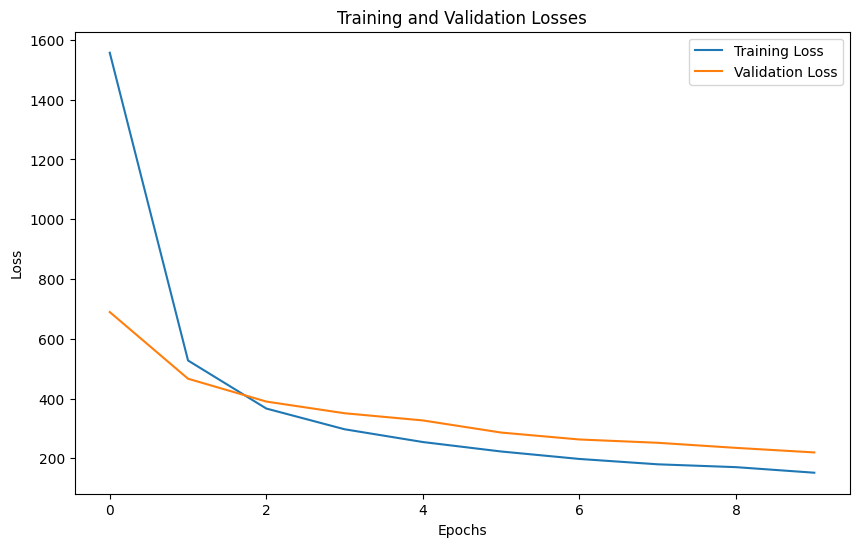

In [10]:
####################################################################################################################
# Print the keys in history.history to troubleshoot
print("\nKeys in history.history:")
print(history.history.keys())

# Hardcode the metric names to get all results
train_loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
train_pointwise_regression_loss = history.history.get('pointwise_regression_loss', [])
val_pointwise_regression_loss = history.history.get('val_pointwise_regression_loss', [])
train_compute_irr_top1 = history.history.get('compute_irr_top1', [])
val_compute_irr_top1 = history.history.get('val_compute_irr_top1', [])
train_compute_mrr_top1 = history.history.get('compute_mrr_top1', [])
val_compute_mrr_top1 = history.history.get('val_compute_mrr_top1', [])

# Save the results to a dictionary
results = {
    'best_hyperparameters': {
        'learning_rate': best_hps.get('learning_rate'),
        'alpha': best_hps.get('alpha'),
        'lambda': best_hps.get('lambda')
    },
    'train_loss': train_loss,
    'val_loss': val_loss,
    'test_loss': test_results[0],
    'train_metrics': {
        'pointwise_regression_loss': train_pointwise_regression_loss,
        'compute_irr_top1': train_compute_irr_top1,
        'compute_mrr_top1': train_compute_mrr_top1
    },
    'val_metrics': {
        'val_pointwise_regression_loss': val_pointwise_regression_loss,
        'val_compute_irr_top1': val_compute_irr_top1,
        'val_compute_mrr_top1': val_compute_mrr_top1
    },
    'test_metrics': {
        'pointwise_regression_loss': test_results[1],
        'compute_irr_top1': test_results[2],
        'compute_mrr_top1': test_results[3]
    }
}

# Save the dictionary to a pickle file
with open("/content/drive/MyDrive/Colab Notebooks/GNN/Baseline 1: GRU Stacked/Best_hp_BM1_10.pkl", "wb") as f:
    pickle.dump(results, f)

# Plot the training and validation losses for the best combination
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [8]:
import pickle

# Load the results from the pickle file
with open("/content/drive/MyDrive/Colab Notebooks/GNN/Baseline 1: GRU Stacked/Best_hp_BM1_10.pkl", "rb") as f:
    loaded_results = pickle.load(f)

# Extract the loaded hyperparameters
loaded_learning_rate = loaded_results['best_hyperparameters']['learning_rate']
loaded_alpha = loaded_results['best_hyperparameters']['alpha']
loaded_lambda = loaded_results['best_hyperparameters']['lambda']

# Extract the loaded losses
loaded_train_loss = loaded_results['train_loss']
loaded_val_loss = loaded_results['val_loss']
loaded_test_loss = loaded_results['test_loss']

# Extract the loaded metrics
loaded_train_metrics = loaded_results['train_metrics']
loaded_val_metrics = loaded_results['val_metrics']
loaded_test_metrics = loaded_results['test_metrics']

# Print the loaded hyperparameters
print("\nLoaded Best Hyperparameter Combination:")
print(f"Loaded Learning Rate: {loaded_learning_rate}")
print(f"Loaded Alpha: {loaded_alpha}")
print(f"Loaded Lambda: {loaded_lambda}")

# Print the loaded losses
print("\nLoaded Losses:")
print(f"Loaded Training Loss: {loaded_train_loss}")
print(f"Loaded Validation Loss: {loaded_val_loss}")
print(f"Loaded Test Loss: {loaded_test_loss}")

# Print the loaded metrics
print("\nLoaded Training Metrics:")
for metric_name, metric_values in loaded_train_metrics.items():
    print(f"{metric_name}: {metric_values}")

print("\nLoaded Validation Metrics:")
for metric_name, metric_values in loaded_val_metrics.items():
    print(f"{metric_name}: {metric_values}")

print("\nLoaded Test Metrics:")
for metric_name, metric_value in loaded_test_metrics.items():
    print(f"{metric_name}: {metric_value}")


Loaded Best Hyperparameter Combination:
Loaded Learning Rate: 0.001
Loaded Alpha: 1.2
Loaded Lambda: 0.01

Loaded Losses:
Loaded Training Loss: [1920.0692138671875, 649.3838500976562, 455.18621826171875, 375.6127014160156, 315.8409118652344, 284.7153015136719, 254.1969451904297, 238.5016326904297, 214.1497039794922, 201.79049682617188, 184.8152618408203, 173.99508666992188, 158.58041381835938, 152.4155731201172, 143.7318878173828]
Loaded Validation Loss: [850.0626831054688, 565.232421875, 476.5522155761719, 413.0233154296875, 389.908447265625, 363.4489440917969, 340.82080078125, 310.7287292480469, 300.3431091308594, 288.0691833496094, 269.8995056152344, 258.4646301269531, 251.0688934326172, 237.3319091796875, 230.6551055908203]
Loaded Test Loss: 230.6551513671875

Loaded Training Metrics:
pointwise_regression_loss: [0.16623996198177338, 0.013429529964923859, 0.00732900807633996, 0.005614773370325565, 0.00419300002977252, 0.0036713050212711096, 0.0030557550489902496, 0.0029216206166893